# Imports

In [1]:
# !pip install rasterio matplotlib folium GDAL
# !pip install geopandas
# !pip install s2cloudless

In [ ]:
import numpy as np
import rasterio
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from rasterio.plot import show
from sklearn.preprocessing import StandardScaler
from shapely.geometry import box
from rasterio.mask import mask
from rasterio.merge import merge

# Constants

In [ ]:
#Panama
shape_path = "data/Panama/panama_rect.shx"
iceye_path = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
s2_merged_path = "data/Panama/S2_merged_20211210.tif"
s1_path = "data/Panama/S1_inter_20220128_20220317.geo.unw.tif"
capella_path = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"
new_shapefile = ""

list_unmerged_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
FIRST_LOCATION_RUN = False

RASTER_HEIGHT = 4354 # size of 20 m by 20 m (S2)
RASTER_WIDTH = 3938
WANTED_RES = 20

# Data preprocessing

## Once per location

In [4]:
def find_largest_rectangle_geometry(polygon, steps=30, aspect_ratio=1.1):
    minx, miny, maxx, maxy = polygon.bounds
    best_rect = None
    best_area = 0

    x_vals = np.linspace(minx, maxx, steps)
    y_vals = np.linspace(miny, maxy, steps)

    for cx in x_vals:
        for cy in y_vals:
            # Binary search on width (since height = width * aspect_ratio)
            low, high = 0, min(maxx - minx, maxy - miny)
            while high - low > 1e-2:
                w = (low + high) / 2
                h = w * aspect_ratio  # enforce vertical orientation
                candidate = box(cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2)
                if polygon.contains(candidate):
                    low = w
                    area = w * h
                    if area > best_area:
                        best_area = area
                        best_rect = candidate
                else:
                    high = w
    return best_rect

In [5]:
def merge_rasters(list_of_files, output_path):
    # Open the two datasets
    src_files_to_mosaic = []
    for fp in list_of_files:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge them
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Get metadata from one of the input files
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0]  # Number of bands
    })

    # Output path
    output_path = 'data/Panama/S2_merged_20211210.tif'

    # Write to disk
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    print(f"Merged file saved to {output_path}")

## Shapefile

In [6]:
def get_aoi_geometry(file_path, need_resizing=False, save_to=''):
    if not need_resizing:
        aoi = gpd.read_file(file_path)['geometry']
    else:
        aoi = gpd.read_file(file_path)['geometry']
        aoi = gpd.GeoSeries([find_largest_rectangle_geometry(aoi[0])])
        aoi.to_file(save_to)
    return aoi

In [7]:
aoi = get_aoi_geometry(shape_path, FIRST_LOCATION_RUN)
aoi = aoi.set_crs("EPSG:4326", allow_override=True)

## Optical

Data is already stacked as 12 bands in the desired region
- Normalize data
- Compute desired VIs and BPVs
- Later everything will have to check crs and change resolution

In [ ]:
def clip_raster(file_path, geometry): # might need to add resample here
    with rasterio.open(file_path) as src:
        # Reproject geometry to match raster CRS
        geometry = geometry.to_crs(src.crs)

        clipped_image, clipped_transform = mask(src, geometry, crop=True)
        clipped_profile = src.profile
        clipped_profile.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform
        })

    return clipped_image, clipped_profile


def min_max_normalize(array):
    return (array - array.min()) / (array.max() - array.min())


def compute_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-6)

def compute_evi(nir, red, blue):
    return 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)

def compute_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-6)

def compute_brightness(blue, green, red):
    return (blue + green + red) / 3
## potentially add more vegetation indicies

### Sentinel 2

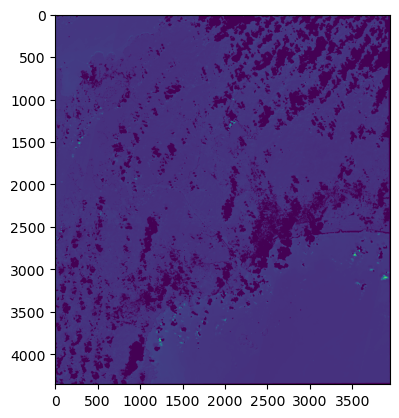

<Axes: >

In [ ]:
if FIRST_LOCATION_RUN:
    merge_rasters(list_unmerged_rasters, s2_merged_path)

s2_data, s2_profile = clip_raster(s2_merged_path, aoi.geometry)

plt.imshow(s2_data, cmap='gray') # need to make the masked areas into nans
plt.colorbar()
plt.title('Band 1 of S2 clipped')
plt.show()

In [48]:
s2_profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 3938, 'height': 4354, 'count': 12, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 17N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32617"]]'), 'transform': Affine(20.0, 0.0, 613940.0,
       0.0, -20.0, 1048840.0), 'blockxsize': 5490, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

In [ ]:
# rgb = [normalize(red), normalize(green), normalize(blue)]

# rgb_stack = np.dstack(rgb)

# # Convert raster CRS to Cartopy CRS
# if isinstance(crs, rCRS):
#     epsg_code = crs.to_epsg()
#     if epsg_code is not None:
#         raster_crs = ccrs.epsg(epsg_code)
#     else:
#         raster_crs = ccrs.PlateCarree()  # fallback
# else:
#     raster_crs = ccrs.PlateCarree()

# # Plot
# fig = plt.figure(figsize=(10, 10))
# ax = plt.axes(projection=ccrs.PlateCarree())

# ax.set_extent(extent, crs=raster_crs)
# im = ax.imshow(rgb_stack, extent=extent, transform=raster_crs)
# gpd.GeoSeries([aoi.geometry[0]]).plot(ax=ax, color='lightblue', edgecolor='blue', label='Rotated Polygon')

# ax.coastlines(resolution='50m')
# ax.add_feature(cfeature.BORDERS, linestyle=':')
# # gl = ax.gridlines(crs=raster_crs, draw_labels=True, color='gray', alpha=0.3)
# # gl.xlabel_style = {'size': 10}
# # gl.ylabel_style = {'size': 10}
# # gl.top_labels = False
# # gl.right_labels = False

# cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.07)
# cbar.ax.tick_params(labelsize=12)  

# plt.title("Merged Raster with World Map")
# plt.show()

## SAR

SAR Interferograms (ICEYE, Capella, Sentinel-1):
- Goldstein or Lee Filtering: To suppress speckle noise.
- Phase Unwrapping: Convert wrapped phase to continuous values using SNAPHU or similar.
- Temporal and Spatial Filtering: Reduce atmospheric and orbital errors (e.g., via temporal stacking or filtering methods like SBAS or PSI).

### Sentinel 1

Interferogram
- Need to normalize
- check crs and possibly change resolution

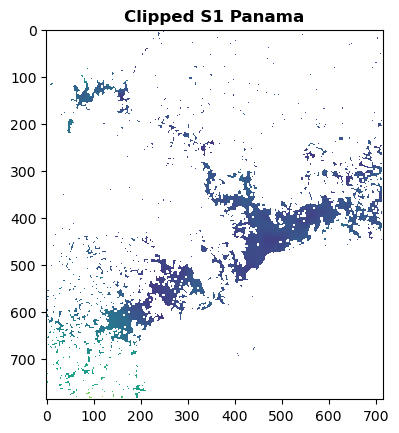

<Axes: title={'center': 'Clipped S1 Panama'}>

In [ ]:
s1_interferogram, s1_interferogram_profile = clip_raster(s1_path, aoi.geometry)

plt.imshow(s1_interferogram, cmap='gray')
plt.colorbar()
plt.title('Clipped S1 Panama')
plt.show()

In [47]:
s1_interferogram_profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 715, 'height': 786, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.000999999999999997, 0.0, -79.96277780000001,
       0.0, -0.001, 9.4845), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

### Capella

In [134]:
with rasterio.open(capella_path) as src:
    capella = src.read(1)  # Read the first band
    capella_profile = src.profile

capella

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [137]:
capella.mean()

29.22181603400491

### Iceye

In [ ]:
from rasterio.enums import Resampling
def clip_raster(file_path, geometry):
    with rasterio.open(file_path) as src:
        # Clip the raster with geometry
        out_image, out_transform = mask(src, geometry, crop=True)
        out_meta = src.meta.copy()

        # Calculate new transform and shape based on the desired resolution
        width = int((out_image.shape[2] * src.res[0]) / WANTED_RES)
        height = int((out_image.shape[1] * src.res[1]) / WANTED_RES)
        new_transform = out_transform * out_transform.scale(
            (out_image.shape[2] / width),
            (out_image.shape[1] / height)
        )

        # Prepare output array and metadata
        new_data = np.empty(shape=(src.count, height, width), dtype=src.dtypes[0])
        new_meta = out_meta.copy()
        new_meta.update({
            "height": height,
            "width": width,
            "transform": new_transform
        })

        # Resample the raster
        for i in range(1, src.count + 1):
            reproject(
                source=out_image[i - 1],
                destination=new_data[i - 1],
                src_transform=out_transform,
                src_crs=src.crs,
                dst_transform=new_transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear
            )

    return out_image, new_meta

iceye_image, iceye_profile = clip_raster(iceye_path, aoi.geometry)
iceye_profile

(8.983152841195215e-05, 8.983152841195215e-05)


AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [ ]:
iceye_image, iceye_profile = clip_raster(iceye_path, aoi.geometry)

vmin, vmax = np.percentile(iceye_image[0], [0, 99])
iceye_no_outliers = np.where(iceye_image[0] <= vmax, iceye_image[0], np.nan)

plt.imshow(iceye_no_outliers, cmap='gray')
plt.colorbar()
plt.title("Iceye with Clipped Percentiles")
plt.show()

## Data stacking + ref data

In [ ]:
# def stack_and_flatten(*arrays):
#     mask = np.all([~np.isnan(arr) for arr in arrays], axis=0)
#     stacked = np.stack([arr[mask] for arr in arrays], axis=1)
#     return stacked, mask

# features, valid_mask = stack_and_flatten(vv, vh, coherence, ndvi, evi, ndwi, vv_vh_ratio)

## Reference Data

In [ ]:
# agb, _ = read_band("AGB_REFERENCE.tif")
# agb_flat = agb[valid_mask]

# feature_names = ['VV', 'VH', 'Coherence', 'NDVI', 'EVI', 'NDWI', 'VV_VH_ratio']
# df = pd.DataFrame(features, columns=feature_names)
# df['AGB'] = agb_flat


# Train model

In [ ]:
# X = df[feature_names].values
# y = df['AGB'].values

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Multiple linear regression

## Random forest

In [ ]:
# model = RandomForestRegressor(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# print(f"R²: {r2_score(y_test, y_pred):.3f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")


## Convolutional neural networks

## Gradient boosted trees